In [ ]:
NAME:TAIMOOR SHAHID    ENROLL:01-136242-045
 ANALYSIS:AQI + GAS-BASED ALERT SYSTEM (using CO + NO2 + NOx)

In [1]:
# uploading csv dataset file from locall drive.
from google.colab import files
uploaded = files.upload()


Saving AirQuality.csv to AirQuality.csv


In [6]:
#loading/mounting csv datset file in colab.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Loading our dataset uploaded CSV
df = pd.read_csv("AirQuality.csv", sep=';')
print(df.shape)
df.head()

(9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [35]:
# 2) ensure Datetime exists (try common names)
if "Datetime" in df.columns:
    df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
else:
    # try variations
    for cand in ["Date", "date", "Time", "time", "Date;Time", "date;time"]:
        if cand in df.columns:
            df["Datetime"] = pd.to_datetime(df[cand], errors="coerce")
            break
    # if still missing, try building from Date + Time
    if "Datetime" not in df.columns and ("Date" in df.columns and "Time" in df.columns):
        df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")
# If still missing, use the first column as datetime attempt
if "Datetime" not in df.columns:
    df["Datetime"] = pd.to_datetime(df.iloc[:,0], errors="coerce")

In [36]:
# 3) show which gas columns we have
expected = ["CO(GT)","NO2(GT)","NOx(GT)","C6H6(GT)"]
found = [c for c in expected if c in df.columns]
print("Gas columns found:", found)


Gas columns found: ['CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)']


In [37]:
# 4) make sure gas columns are numeric and -200 were handled earlier, but re-check
df.replace(-200, pd.NA, inplace=True)
for c in found:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [38]:
# 5) compute Gas_AQI using available gas columns (use only columns that have data)
weights = {"CO(GT)":50, "NO2(GT)":20, "NOx(GT)":0.5, "C6H6(GT)":10}
used_cols = [c for c in found if df[c].notna().sum() > 0]
print("Using columns for Gas_AQI:", used_cols)
if not used_cols:
    raise RuntimeError("No usable gas columns with numeric data found. Check file.")

df["Gas_AQI"] = 0.0
for c in used_cols:
    df["Gas_AQI"] += df[c].fillna(0) * weights.get(c, 1.0)

Using columns for Gas_AQI: ['CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)']


In [39]:
# 6) classify Gas_AQI into categories
def classify(v):
    if pd.isna(v): return "Unknown"
    v = float(v)
    if v <= 50: return "Good"
    if v <= 100: return "Moderate"
    if v <= 150: return "Unhealthy for Sensitive"
    if v <= 200: return "Unhealthy"
    if v <= 300: return "Very Unhealthy"
    return "Hazardous"

df["AQI_Category"] = df["Gas_AQI"].apply(classify)

In [40]:
# 7) Show stats and a few rows
print("\nGas_AQI summary:")
display(df["Gas_AQI"].describe())
print("\nAQI category counts:")
display(df["AQI_Category"].value_counts(dropna=False))
display(df[["Datetime"] + used_cols + ["Gas_AQI","AQI_Category"]].head(8))



Gas_AQI summary:


,Gas_AQI
count,9471.000000
mean,2125.998997
std,1421.270419
min,0.000000
25%,1109.750000
50%,2163.500000
75%,3041.250000
max,7764.000000



AQI category counts:


,count
AQI_Category,
Hazardous,7759
Good,604
Moderate,558
Unhealthy for Sensitive,271
Very Unhealthy,154
Unhealthy,125


,Datetime,CO(GT),NO2(GT),NOx(GT),C6H6(GT),Gas_AQI,AQI_Category
0,2004-10-03,2.6,113.0,166.0,11.9,2592.0,Hazardous
1,2004-10-03,2.0,92.0,103.0,9.4,2085.5,Hazardous
2,2004-10-03,2.2,114.0,131.0,9.0,2545.5,Hazardous
3,2004-10-03,2.2,122.0,172.0,9.2,2728.0,Hazardous
4,2004-10-03,1.6,116.0,131.0,6.5,2530.5,Hazardous
5,2004-10-03,1.2,96.0,89.0,4.7,2071.5,Hazardous
6,2004-11-03,1.2,77.0,62.0,3.6,1667.0,Hazardous
7,2004-11-03,1.0,76.0,62.0,3.3,1634.0,Hazardous


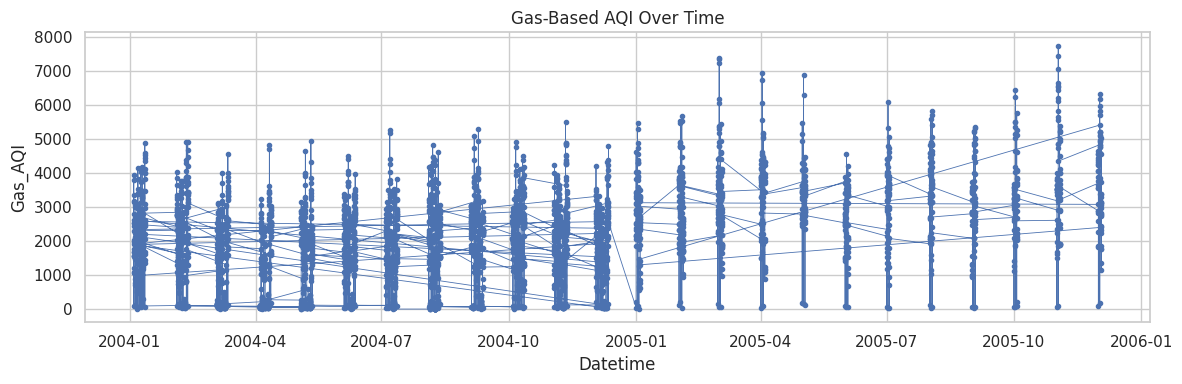

In [41]:
# 8) PLOT 1: Gas_AQI over time (for rows with valid datetime)
plt.figure(figsize=(12,4))
plot_df = df.dropna(subset=["Datetime","Gas_AQI"])
plt.plot(plot_df["Datetime"], plot_df["Gas_AQI"], marker='.', linewidth=0.6)
plt.xlabel("Datetime")
plt.ylabel("Gas_AQI")
plt.title("Gas-Based AQI Over Time")
plt.tight_layout()
plt.show()

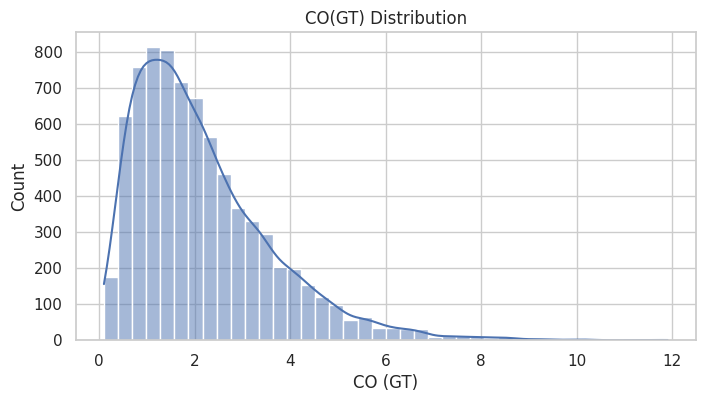

In [42]:
# 9) PLOT 2: CO distribution (if available)
if "CO(GT)" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["CO(GT)"].dropna(), bins=40, kde=True)
    plt.title("CO(GT) Distribution")
    plt.xlabel("CO (GT)")
    plt.show()
else:
    print("CO(GT) not present; skipping CO histogram.")

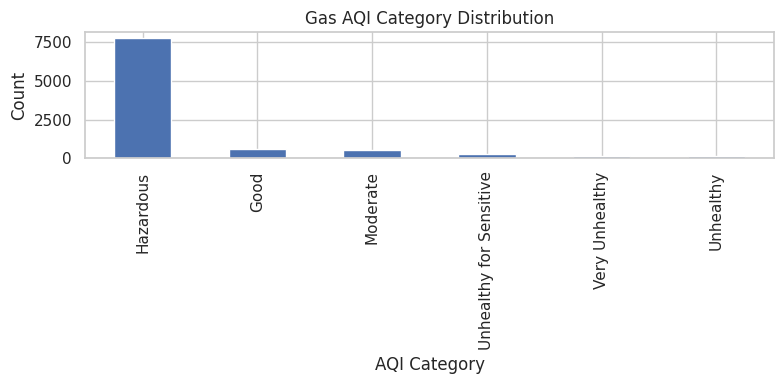

In [43]:

# 10) PLOT 3: AQI Category distribution (exclude Unknown for clarity)
vc = df["AQI_Category"].value_counts()
vc_plot = vc.drop(labels=["Unknown"], errors='ignore')
if vc_plot.sum() > 0:
    plt.figure(figsize=(8,4))
    vc_plot.plot(kind="bar")
    plt.title("Gas AQI Category Distribution")
    plt.xlabel("AQI Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No non-Unknown AQI categories to plot.")

In [44]:
# 11) ALERT SYSTEM: thresholds and alert rows
CO_THRESHOLD = 5       # example thresholds, adjust if you want
NO2_THRESHOLD = 200
GAS_AQI_THRESHOLD = 150

def gas_alerts(row):
    a = []
    if "CO(GT)" in row.index and not pd.isna(row["CO(GT)"]) and row["CO(GT)"] > CO_THRESHOLD:
        a.append("High CO")
    if "NO2(GT)" in row.index and not pd.isna(row["NO2(GT)"]) and row["NO2(GT)"] > NO2_THRESHOLD:
        a.append("High NO2")
    if not pd.isna(row["Gas_AQI"]) and row["Gas_AQI"] > GAS_AQI_THRESHOLD:
        a.append("High Gas_AQI")
    return a

df["Alerts"] = df.apply(gas_alerts, axis=1)
alerts_df = df[df["Alerts"].apply(lambda x: len(x) > 0)].copy()
print("\nNumber of alert rows found:", len(alerts_df))
display(alerts_df[["Datetime"] + used_cols + ["Gas_AQI","AQI_Category","Alerts"]].head(10))


Number of alert rows found: 8038


,Datetime,CO(GT),NO2(GT),NOx(GT),C6H6(GT),Gas_AQI,AQI_Category,Alerts
0,2004-10-03,2.6,113.0,166.0,11.9,2592.0,Hazardous,[High Gas_AQI]
1,2004-10-03,2.0,92.0,103.0,9.4,2085.5,Hazardous,[High Gas_AQI]
2,2004-10-03,2.2,114.0,131.0,9.0,2545.5,Hazardous,[High Gas_AQI]
3,2004-10-03,2.2,122.0,172.0,9.2,2728.0,Hazardous,[High Gas_AQI]
4,2004-10-03,1.6,116.0,131.0,6.5,2530.5,Hazardous,[High Gas_AQI]
5,2004-10-03,1.2,96.0,89.0,4.7,2071.5,Hazardous,[High Gas_AQI]
6,2004-11-03,1.2,77.0,62.0,3.6,1667.0,Hazardous,[High Gas_AQI]
7,2004-11-03,1.0,76.0,62.0,3.3,1634.0,Hazardous,[High Gas_AQI]
8,2004-11-03,0.9,60.0,45.0,2.3,1290.5,Hazardous,[High Gas_AQI]
10,2004-11-03,NaN,34.0,21.0,1.3,703.5,Hazardous,[High Gas_AQI]


In [45]:

# 12) Save personal output and provide download link
out_name = "taimoor_gas_aqi_alerts.csv"
df.to_csv(out_name, index=False)
from google.colab import files
files.download(out_name)
print(f"\nSaved and started download: {out_name}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved and started download: taimoor_gas_aqi_alerts.csv
